# Symbol Classification

In [1]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
% matplotlib inline

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torch.nn.functional as F  # useful stateless functions
from torchvision import transforms
from sklearn.metrics import confusion_matrix

## Load data and create dataset

In [2]:
# Data loading code
data_dir = "D:/Downloads/DeepScores_archive0/Mask_RCNN/symbol_data"
traindir = os.path.join(data_dir, 'train')
valdir = os.path.join(data_dir, 'val')
testdir = os.path.join(data_dir, 'test')

# pretrained model requies input image to be at least 224x224
img_size = (224,224)

# need normalization to use pretrained model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# image augmentation needed
data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=3), # can convert the image to grayscale to reduce size
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize,
    ])

# form train and val data
image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms)
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=100,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

train_class_names = image_datasets['train'].classes
print(len(train_class_names)) # check the dataset is formed correctly
val_class_names = image_datasets['val'].classes
print(len(val_class_names)) # check the dataset is formed correctly
test_class_names = image_datasets['test'].classes
print(len(test_class_names)) # check the dataset is formed correctly

79
79
79


In [3]:
# common_ele = set(val_class_names).intersection(test_class_names)
# total_common = common_ele.intersection(train_class_names)
# print(sorted(set(test_class_names) - total_common))
# print(len(total_common))

## Build nn to train the data

You have an option to use GPU by setting the flag to True below. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, torch.cuda.is_available() will return False and this notebook will fallback to CPU mode.

The global variables dtype and device will control the data types throughout this assignment.

In [21]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 50

print('using device:', device)

print(type(dataloaders['train']))

using device: cuda
<class 'torch.utils.data.dataloader.DataLoader'>


# PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [5]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
#     model = model.to(device=device)  # move the model parameters to CPU/GPU
    # store the loss and accuracy history 
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    for e in range(epochs):             
        for t, (x, y) in enumerate(dataloaders['train']):
            model.train()  # put model to training mode
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_history.append(loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
#                 print('Train accuracy') 
#                 train_acc = check_accuracy_part34(dataloaders['train'], model)
#                 train_acc_history.append(train_acc)
#                 print('Val accuracy') 
#                 val_acc = check_accuracy_part34(dataloaders['val'], model)
#                 val_acc_history.append(val_acc)
#                 print()
    return loss_history, train_acc_history, val_acc_history

### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [6]:
def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return 100*acc

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


## Transfer learning using ResNet

In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 79) # change the last fully connected layer to 79, we have 79 symbol classes
model_ft = model_ft.to(device)

Iteration 0, loss = 4.3756
Iteration 50, loss = 0.4218
Iteration 100, loss = 0.1676
Iteration 150, loss = 0.1407
Iteration 200, loss = 0.2705
Iteration 250, loss = 0.1099
Iteration 300, loss = 0.1115
Iteration 350, loss = 0.1690
Iteration 400, loss = 0.0665
Iteration 450, loss = 0.1859
Iteration 500, loss = 0.1527
Iteration 550, loss = 0.2091
Iteration 600, loss = 0.3158
Iteration 650, loss = 0.1295
Iteration 700, loss = 0.1404
Iteration 750, loss = 0.0810
Iteration 800, loss = 0.1401
Iteration 850, loss = 0.0803
Iteration 900, loss = 0.1115
Iteration 950, loss = 0.2000
Iteration 1000, loss = 0.1108
Iteration 1050, loss = 0.2098
Iteration 1100, loss = 0.1023
Iteration 1150, loss = 0.1529
Iteration 1200, loss = 0.1395
Iteration 1250, loss = 0.1618
Iteration 1300, loss = 0.0987
Iteration 1350, loss = 0.1104
Iteration 1400, loss = 0.1201
Iteration 1450, loss = 0.0933
Iteration 1500, loss = 0.0737
Iteration 1550, loss = 0.1354
Iteration 1600, loss = 0.1127
Iteration 1650, loss = 0.1066
Ite

Text(0.5,1,'Two Layer CNN, Optimizer = SGD')

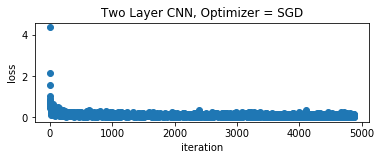

In [11]:
learning_rate = 1e-3

model = None
optimizer = None

# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model_ft.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

loss_history, train_acc_history, val_acc_history = train_part34(model_ft, optimizer, epochs = 1)

# plot loss history
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Modified ResNet18, Optimizer = Adam')

# plt.subplot(2, 1, 2)
# plt.plot(train_acc_history, '-o')
# plt.plot(val_acc_history, '-o')
# plt.legend(['train', 'val'], loc='upper left')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.show()

Text(0.5,1,'Modified ResNet18, Optimizer = Adam')

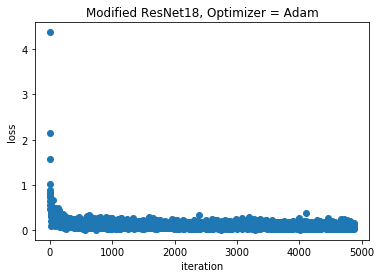

In [12]:
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Modified ResNet18, Optimizer = Adam')

In [13]:
torch.save(model_ft.state_dict(), "D:/Downloads/DeepScores_archive0/Mask_RCNN/deepscore/model_ft.pth")

In [24]:
#load saved model to do inference:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 79)
model_ft.load_state_dict(torch.load("D:/Downloads/DeepScores_archive0/Mask_RCNN/deepscore/model_ft.pth"))
model_ft.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [25]:
test_acc = check_accuracy_part34(dataloaders['test'], model_ft)
print('Test accuracy:', test_acc)

Got 37097 / 39423 correct (94.10)
Test accuracy: 94.09989092661645


In [28]:
# plot the confusion matrix in a nice way
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
model_ft.eval()  # one layer cnn turned out to perform the best on test data
y_preds = []
y_true = []
with torch.no_grad():
    for x, y in dataloaders['test']:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        y_true.append(y.cpu().numpy()) # cannot directly convert cuda tensor to numpy, need to load to cpu first
        scores = model_ft(x)
        _, preds = scores.max(1)
        y_preds.append(preds.cpu().numpy())
        
# print(np.concatenate(y_preds, axis = 0))
# print('  s')
# print(y_true)
cm = confusion_matrix(np.concatenate(y_true, axis = 0), np.concatenate(y_preds, axis = 0))

NameError: name 'label_type' is not defined

C:\Users\johnl\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Confusion matrix, without normalization
[[4.93447393       -inf       -inf ...       -inf       -inf       -inf]
 [      -inf 5.89164421       -inf ...       -inf       -inf       -inf]
 [      -inf       -inf 7.08590146 ...       -inf       -inf       -inf]
 ...
 [      -inf       -inf       -inf ... 2.48490665       -inf       -inf]
 [      -inf       -inf       -inf ...       -inf 5.82894562       -inf]
 [      -inf       -inf       -inf ...       -inf       -inf 4.69134788]]


NameError: name 'itertools' is not defined

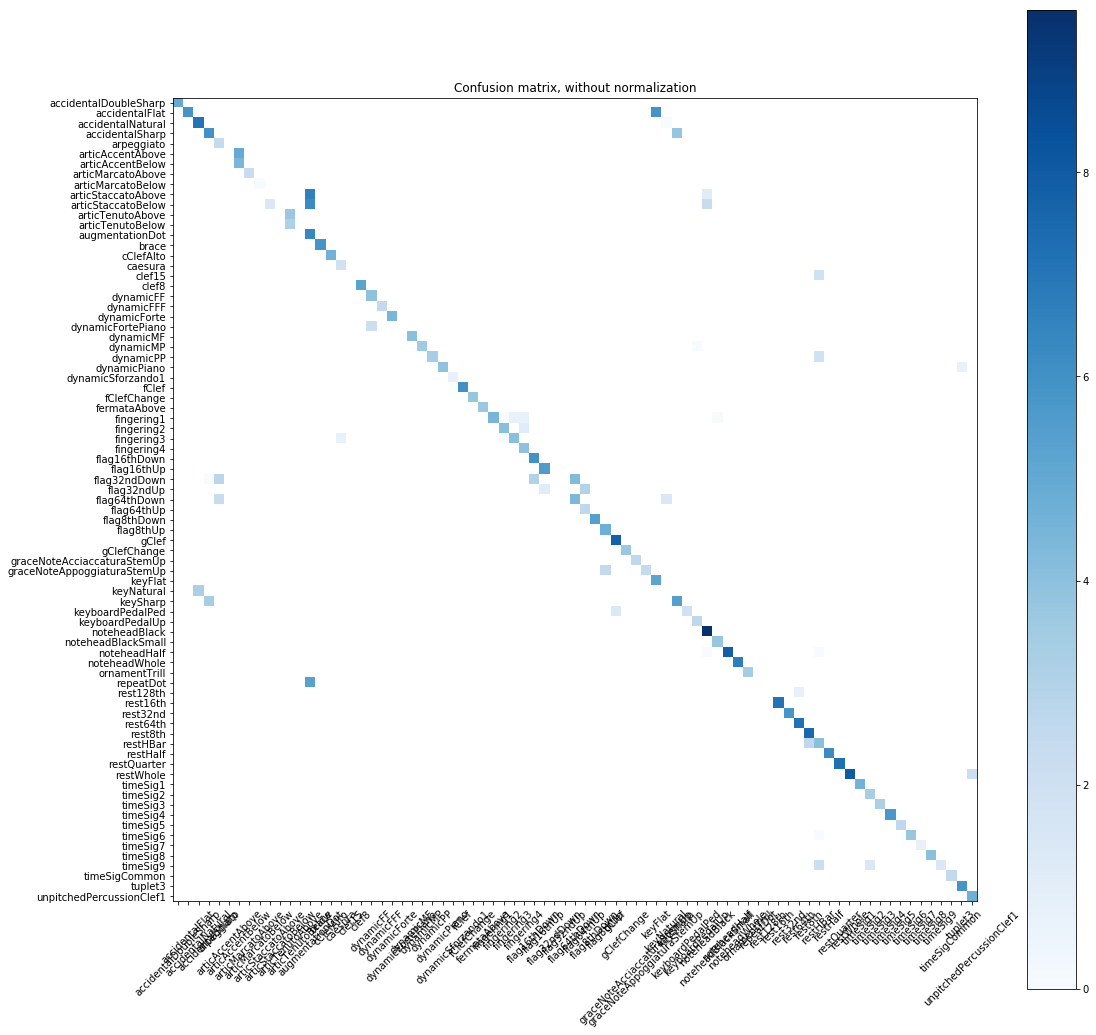

In [39]:
# print(test_class_names)
# Plot non-normalized confusion matrix
plt.figure(figsize = (18,18))
plot_confusion_matrix(np.log(cm), classes=test_class_names,
                      title='Confusion matrix, without normalization')


Confusion matrix, without normalization
[[ 139    0    0 ...    0    0    0]
 [   0  362    0 ...    0    0    0]
 [   0    0 1195 ...    0    0    0]
 ...
 [   0    0    0 ...   12    0    0]
 [   0    0    0 ...    0  340    0]
 [   0    0    0 ...    0    0  109]]


NameError: name 'itertools' is not defined

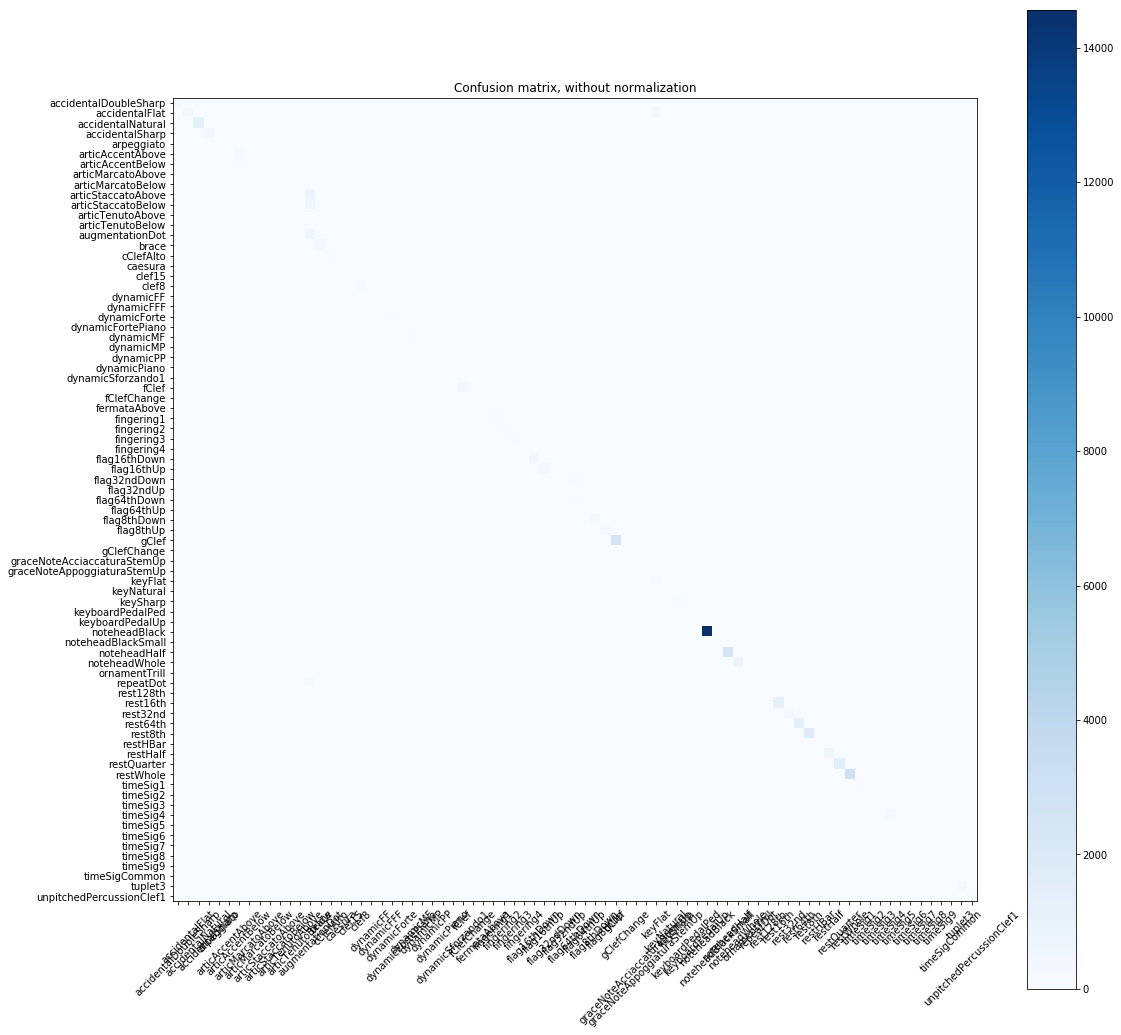

In [40]:
plt.figure(figsize = (18,18))
plot_confusion_matrix(cm, classes=test_class_names,
                      title='Confusion matrix, without normalization')